In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import colors
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily as ctx # Background tiles
import warnings
from esda.getisord import G_Local

In [16]:
url_listings_2024  = 'data/raw/listings.csv.gz'
url_listings_2021 = 'data/raw/2021_listings.csv.gz'
url_listings_2022 = 'data/raw/2022_listings.csv.gz'
url_listings_2023 = 'data/raw/2023_listings.csv.gz'
url_msoa_map = 'data/shapefiles/MSOA_2011_London_gen_MHW.shp'



In [17]:
df_listings_2024 = pd.read_csv(url_listings_2024, compression='gzip', low_memory=False) #compression='gzip' is to unzip the file
df_listings_2021 = pd.read_csv(url_listings_2021, compression='gzip', low_memory=False)
df_listings_2022 = pd.read_csv(url_listings_2022, compression='gzip', low_memory=False)
df_listings_2023 = pd.read_csv(url_listings_2023, compression='gzip', low_memory=False)
df_msoa_map = gpd.read_file(url_msoa_map)

In [18]:
columns_2024 = set(df_listings_2024.columns)
columns_2021 = set(df_listings_2021.columns)
columns_2022 = set(df_listings_2022.columns)
columns_2023 = set(df_listings_2023.columns)

diff_2024_2021 = columns_2024.symmetric_difference(columns_2021)
diff_2024_2022 = columns_2024.symmetric_difference(columns_2022)
diff_2024_2023 = columns_2024.symmetric_difference(columns_2023)


In [19]:
#add a new column called year to each dataframe
df_listings_2024['year'] = 2024
df_listings_2021['year'] = 2021
df_listings_2022['year'] = 2022
df_listings_2023['year'] = 2023
df_listings_combined = pd.concat([df_listings_2024, df_listings_2021, df_listings_2022, df_listings_2023], axis=0, ignore_index=True)   
#select the column I want to use
columns_to_use = ['id', 'listing_url', 'name', 'host_id', 'host_name', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'price', 'number_of_reviews','review_scores_rating', 'year']
df_listings_combined = df_listings_combined[columns_to_use]

In [20]:
#I don't know what are the cloumn host_listings_count and host_total_listings_count different, so I will select by host id annd year range to check the da
host_id = 54730
start_year = 2021
end_year = 2024

def select_function(df, host_id, start_year, end_year):
    return df[(df['host_id'] == host_id) & (df['year'] >= start_year) & (df['year'] <= end_year)]

df_listings_combined_by_host_id_and_year_range = select_function(df_listings_combined, host_id, start_year, end_year)

In [21]:
#after checking the data, I find they are wrong, so I will count it by myself. for example host id 54730 in 2023 has 2 listings, but the host_listings_count is 3
df_host_listings_count = df_listings_combined.groupby(['host_id', 'year'])['id'].nunique().reset_index()
df_host_listings_count.columns = ['host_id', 'year', 'host_listings_count']
df_host_listings_count

filtered_df = df_host_listings_count[df_host_listings_count['host_id'] == 54730]

In [22]:
#count the category of host_listings_count
bins = [0, 2, float('inf')] #catogrize host_listings_count into <=1 and >2
labels = ['Single Property hosts', 'Multiple Properties hosts']
df_host_listings_count['category'] = pd.cut(df_host_listings_count['host_listings_count'], bins=bins, labels=labels, right=False)

In [23]:
df_new_listings_combined = df_listings_combined.merge(df_host_listings_count, on=['host_id', 'year'], how='left') 
df_new_listings_combined = df_new_listings_combined.rename(columns={'host_listings_count_y': 'new_host_listings_count'})
df_new_listings_combined #make the latitude and longitude to geo dara frame point and create the new column called geometry_point

points = [Point(xy) for xy in zip(df_new_listings_combined['longitude'], df_new_listings_combined['latitude'])]
gdf_new_listings_combined = gpd.GeoDataFrame(df_new_listings_combined, geometry = points)
gdf_new_listings_combined.crs = "EPSG:4326"
gdf_new_listings_combined = gdf_new_listings_combined.rename(columns={'geometry': 'geometry_point'})
gdf_new_listings_combined = gdf_new_listings_combined.set_geometry('geometry_point')

In [24]:
#1.use the df_msoa_map column "geometry" to count the point in the df_new_listings_combined column "geometry_point" (longitude, latitude) 
#2. and split to single property count and multiple properties count by year 
#3. create the percentage of multiple properties  = multiple properties count / (multiple properties count + single property count) by year 

#make sure the coordinate system is the same
df_msoa_map = df_msoa_map.to_crs(epsg=4326)
gdf_new_listings_combined = gdf_new_listings_combined.to_crs(epsg=4326)

# spatial join to count the point in the df_new_listings_combined column "geometry_point" (longitude, latitude) 
gdf_joined = gpd.sjoin(df_msoa_map, gdf_new_listings_combined, how="inner", predicate='contains')

count_properties = gdf_joined.groupby(['MSOA11CD', 'year', 'category'], observed=True).size().unstack(fill_value=0)

# check the column name and add the missing column with 0
expected_columns = ['Single Property hosts', 'Multiple Properties hosts']
for col in expected_columns:
    if col not in count_properties.columns:
        count_properties[col] = 0

# calculate the total properties and percentage of multiple properties
count_properties['Total Properties'] = count_properties.sum(axis=1)
count_properties['Percentage of Multiple Properties'] = (count_properties['Multiple Properties hosts'] / count_properties['Total Properties']) * 100

# if the column "Total Properties" is not in the dataframe, add it with 0
if 'Total Properties' not in count_properties.columns:
    count_properties['Total Properties'] = 0

# index to normal column
count_properties.reset_index(inplace=True)
df_count_properties = count_properties

In [25]:
df_msoa_map_subset = df_msoa_map[['MSOA11CD', 'geometry']]
df_count_properties_msoa = df_count_properties.merge(df_msoa_map_subset, on='MSOA11CD', how='left')

In [26]:
df = gpd.GeoDataFrame(df_count_properties_msoa, geometry='geometry')
df = df.to_crs(epsg=27700)

# Compute the area of each geometry in square meters
df['area'] = df['geometry'].area

# Calculate density (count per square kilometres)
df['density'] = df['Multiple Properties hosts'] / (df['area'] * 0.001 * 0.001)

In [27]:
year = 2024
df1 = df[df['year'] == year]


In [28]:
df = gpd.GeoDataFrame(df_count_properties_msoa, geometry='geometry')
df = df.to_crs(epsg=27700)
# Compute the area of each geometry in square meters
df['area'] = df['geometry'].area
# Calculate density (count per square kilometres)
df['density'] = df['Single Property hosts'] / (df['area'] * 0.001 * 0.001)
year = 2024
df2 = df[df['year'] == year]

In [30]:
url_boro_map = 'data/shapefiles/London_Borough_Excluding_MHW.shp'
boro = gpd.read_file(url_boro_map)

In [31]:
w = weights.distance.KNN.from_dataframe(df1, k=8)
# Row-standardization
w.transform = "R"

In [32]:
go_i = esda.getisord.G_Local(df1["density"], w)
# Gi*
go_i_star = esda.getisord.G_Local(df1["density"], w, star=True)

import numpy as np

def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec="0.8"
    
    z_mean = g.Zs.mean()
    z_std = g.Zs.std()
    g.Zs_normalized = (g.Zs - z_mean) / z_std

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1, alpha=0.1)

    # Plot HH clusters (Hotspots: Z > 1.96)
    hh = db.loc[(g.Zs_normalized > 1.96) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="#0061ff", edgecolor=ec, linewidth=0.1)

    # Plot LL clusters (Coldspots: Z < -1.96)
    ll = db.loc[(g.Zs_normalized < -1.96) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1, alpha=0.7)
    
    # Style and draw
    contextily.add_basemap(ax,
        crs=db.crs,
        source=contextily.providers.CartoDB.VoyagerNoLabels,
    )
    
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"Comparison of Standardised G{st} statistic between SHL and MHL Density by MSOA", size=13)
    # Remove axis for aesthetics
    ax.set_axis_off()

    return ax




/Users/tsernian/Documents/CASA/CASA0013_FSDS/myenv/lib/python3.9/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


In [45]:
go_i2 = esda.getisord.G_Local(df2["density"], w)
# Gi*
go_i_star2 = esda.getisord.G_Local(df2["density"], w, star=True)

def g_map2(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"
    
    z_mean = g.Zs.mean()
    z_std = g.Zs.std()
    g.Zs_normalized = (g.Zs - z_mean) / z_std

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1, alpha=0)

    # Plot HH clusters (Hotspots: Z > 1.96)
    hh = db.loc[(g.Zs_normalized > 1.96) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="#0061ff", edgecolor=ec, linewidth=0.1, alpha=0.2)

    # Plot LL clusters (Coldspots: Z < -1.96)
    ll = db.loc[(g.Zs_normalized < -1.96) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1, alpha=0.2)
    
    # Style and draw
    contextily.add_basemap(ax,
        crs=db.crs,
        source=contextily.providers.CartoDB.VoyagerNoLabels,
    )
    
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"Comparison of Standardised G{st} statistic between SHL and MHL Listing Density by MSOA", size=13)
    # Remove axis for aesthetics
    ax.set_axis_off()

    return ax



/Users/tsernian/Documents/CASA/CASA0013_FSDS/myenv/lib/python3.9/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


/Users/tsernian/Documents/CASA/CASA0013_FSDS/myenv/lib/python3.9/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


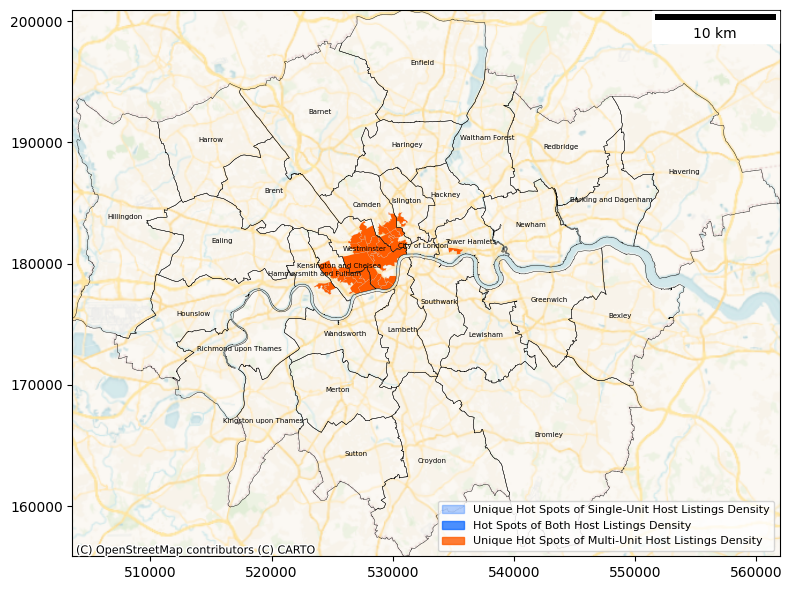

In [46]:
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as Patch

warnings.filterwarnings("ignore", message="Gi* requested, but .*", category=UserWarning)
# Create a single figure and axis
f, ax = plt.subplots(1, 1, figsize=(12, 6))

# Prepare the weights matrix
w = weights.distance.KNN.from_dataframe(df1, k=8)
weights.fill_diagonal(w, 0.5)
w.transform = 'R'  # Row standardization

# Calculate G* statistics and normalize Z-scores
go_i_star = G_Local(df1["density"], w, star=0.5)
z_mean = go_i_star.Zs.mean()
z_std = go_i_star.Zs.std()
go_i_star.Zs_normalized = (go_i_star.Zs - z_mean) / z_std

go_i_star2 = G_Local(df2["density"], w, star=True)
z_mean2 = go_i_star2.Zs.mean()
z_std2 = go_i_star2.Zs.std()
go_i_star2.Zs_normalized = (go_i_star2.Zs - z_mean2) / z_std2
# Identify significant hot spots
sig = go_i_star.p_sim < 0.05
sig2 = go_i_star2.p_sim < 0.05

# Calculate spatial difference and plot if not empty
hh2_geom = gpd.GeoSeries(df2.loc[(go_i_star2.Zs_normalized > 1.96) & (sig2 == True), "geometry"])
hh3_geom = gpd.GeoSeries(df1.loc[(go_i_star.Zs_normalized > 1.96) & (sig == True), "geometry"])
unique_hh3 = hh3_geom.difference(hh2_geom.union_all())
if not unique_hh3.empty:
    unique_hh3.plot(ax=ax, color="#ff5c00", edgecolor="0.8", linewidth=0.1)

# Additional plot settings
boro.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.3)
for idx, row in boro.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['NAME'], fontsize=5, ha='center')

# Add a scalebar
scalebar = ScaleBar(1, units="m", length_fraction=0.2, location='upper right')  
ax.add_artist(scalebar)

# Legend
red_patch_low = mpatches.Patch(color="#0061ff", alpha=0.3, label="Unique Hot Spots of Single-Unit Host Listings Density")
red_patch_high = mpatches.Patch(color="#0061ff", alpha=0.7, label="Hot Spots of Both Host Listings Density")
green = mpatches.Patch(color="#ff5c00", alpha=0.8, label="Unique Hot Spots of Multi-Unit Host Listings Density")
ax.legend(handles=[red_patch_low, red_patch_high, green], loc='lower right', fontsize=8)

# Set bounds
boro_bounds = boro.total_bounds 
ax.set_xlim(boro_bounds[0], boro_bounds[2])
ax.set_ylim(boro_bounds[1], boro_bounds[3])

# Add basemap
contextily.add_basemap(ax, crs=df1.crs, source=contextily.providers.CartoDB.VoyagerNoLabels)

# Tight layout and render the plot
f.tight_layout()
plt.show()


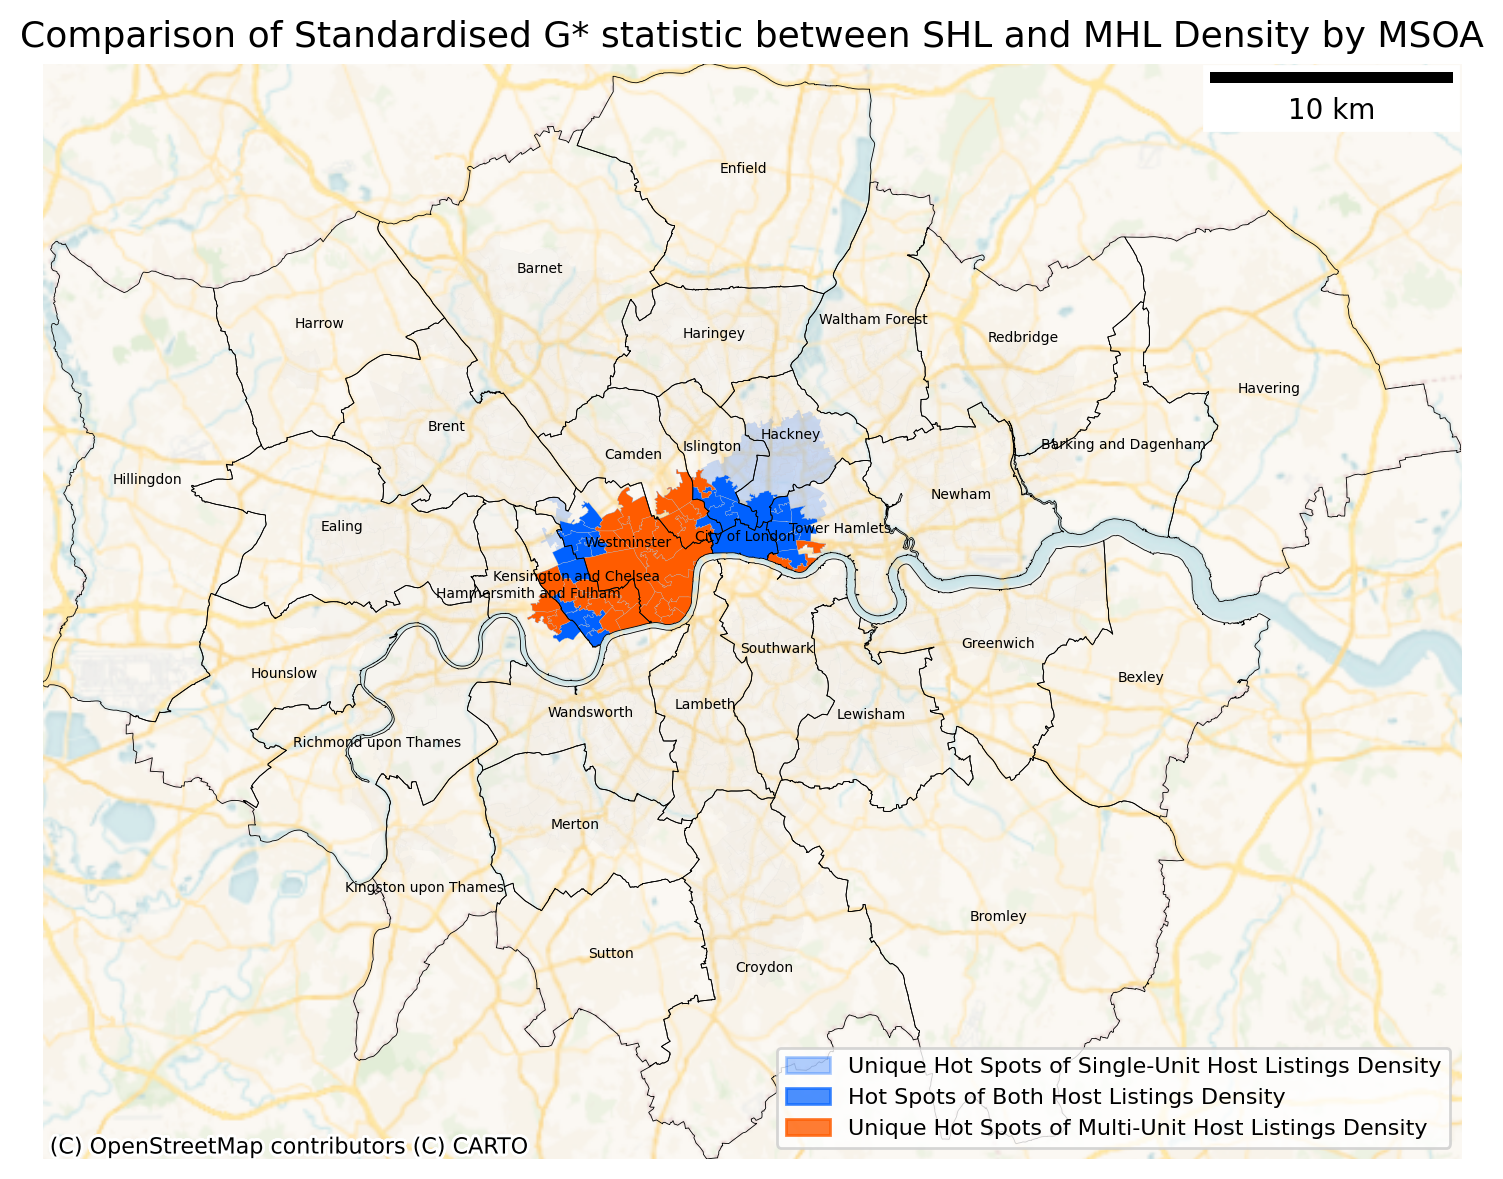

In [58]:
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

f, ax = plt.subplots(1, 1, figsize=(12, 6))

# fill the diagonal with 0.5
w = weights.distance.KNN.from_dataframe(df1, k=8)
go_i_star = esda.getisord.G_Local(df1["density"], w, star=True)

# Plot both maps on the same axis
go_i_star2 = esda.getisord.G_Local(df2["density"], w, star=True)
g_map2(go_i_star2, df2, ax)  
sig2 = go_i_star2.p_sim < 0.05
z_mean = go_i_star2.Zs.mean()
z_std = go_i_star2.Zs.std()
go_i_star2.Zs_normalized = (go_i_star2.Zs - z_mean) / z_std
hh2 = df2.loc[(go_i_star2.Zs_normalized > 1.96) & (sig2 == True), "geometry"]

go_i_star = esda.getisord.G_Local(df1["density"], w, star=True)
g_map(go_i_star, df1, ax)  

sig1 = go_i_star.p_sim < 0.05
z_mean = go_i_star.Zs.mean()
z_std = go_i_star.Zs.std()
go_i_star.Zs_normalized = (go_i_star.Zs - z_mean) / z_std
hh3 = df1.loc[(go_i_star.Zs_normalized > 1.96) & (sig1 == True), "geometry"]

hh2_geom = gpd.GeoSeries(hh2) 
hh3_geom = gpd.GeoSeries(hh3) 

# Spatial difference: Geometries in hh3 but not in hh2
unique_hh3 = hh3_geom.difference(hh2_geom.unary_union)
# Remove empty geometries
unique_hh3 = unique_hh3[~unique_hh3.is_empty]

# Plot unique hotspots of multiple properties host density 
ec = "0.8"
unique_hh3.plot(ax=ax, color="#ff5c00", edgecolor=ec, linewidth=0.1)

boro.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.3)

for idx, row in boro.iterrows():
    # Get the centroid of each polygon
    centroid = row.geometry.centroid
    # Plot the text at the centroid location
    ax.text(centroid.x, centroid.y, row['NAME'], fontsize=5, ha='center')

# Add a scalebar
scalebar = ScaleBar(1, units="m", length_fraction=0.2, location='upper right')  
ax.add_artist(scalebar)

red_patch_low = Patch(color="#0061ff", alpha=0.3, label="Unique Hot Spots of Single-Unit Host Listings Density")
red_patch_high = Patch(color="#0061ff", alpha=0.7, label="Hot Spots of Both Host Listings Density")
green = Patch(color="#ff5c00", alpha=0.8, label="Unique Hot Spots of Multi-Unit Host Listings Density")
ax.legend(handles=[red_patch_low, red_patch_high, green], loc='lower right', fontsize=8)

boro_bounds = boro.total_bounds 
ax.set_xlim(boro_bounds[0], boro_bounds[2])  # minx, maxx
ax.set_ylim(boro_bounds[1], boro_bounds[3])  # miny, maxy

ctx.add_basemap(ax,
        crs=df1.crs,
        source=ctx.providers.CartoDB.VoyagerNoLabels)

# Tight layout to minimise blank spaces
f.tight_layout()

# Render the plot
plt.show()

The variable you are analyzing (e.g., percent in your case) might not have enough variation or low values clustered together to produce significant coldspots.

The spatial weights matrix (KNN with k=8) defines the "neighborhood" for each observation. If k is too small or doesn't capture the true spatial relationships, it can limit the detection of clustering.

k=5, each region only considers its five nearest neighbors. This might not be enough to detect meaningful clusters, especially in sparse data.
A small k can lead to fragmented neighborhoods, reducing the likelihood of identifying significant coldspots.

Normalization ensures that the Z-scores are comparable across datasets by removing differences in scale and distribution. After normalization, a Z-score of 1 in both maps means the same level of clustering relative to the dataset.

Calculate a z-score transformation for both datasets, using their respective means and standard deviations of Gi* scores. This centers the scores relative to their distributions, making them comparable.

Standardize the Gi Z-scores*: Transform the Z-scores of each dataset to have a mean of 0 and a standard deviation of 1.

Interpretation of normalized Z-scores:
Z>1.96: Significant hotspots.
Z<−1.96: Significant coldspots.
Values close to 0: No significant clustering



tutorial for Getis G* can be found below 
https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

In [ ]:
#how to select the right number of K neighbours

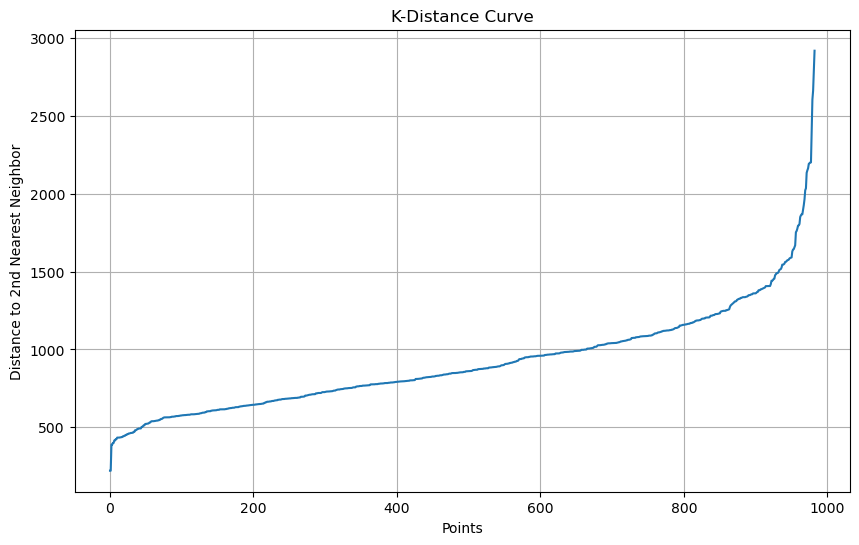

In [38]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

df1['centroid'] = df1.geometry.centroid

# Step 3: Extract centroid coordinates
centroids = np.array([(geom.x, geom.y) for geom in df1['centroid']])

# Step 4: Compute K-Distance for a range of neighbors
k = 20  # Maximum number of neighbors to consider
nbrs = NearestNeighbors(n_neighbors=k).fit(centroids)
distances, indices = nbrs.kneighbors(centroids)

# Step 5: Sort distances for the 2nd neighbor and plot the curve
sorted_distances = np.sort(distances[:, 1], axis=0)  # Adjust index for the kth neighbor
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel("Points")
plt.ylabel("Distance to 2nd Nearest Neighbor")
plt.title("K-Distance Curve")
plt.grid()
plt.show()

In [39]:
df1

,MSOA11CD,year,Single Property hosts,Multiple Properties hosts,Total Properties,Percentage of Multiple Properties,geometry,area,density,centroid
3,E02000001,2024,120,443,563,78.685613,"MULTIPOLYGON (((531667.624 180534.992, 531647....",2.905399e+06,152.474739,POINT (532482.704 181269.31)
7,E02000002,2024,8,5,13,38.461538,"POLYGON ((548881.563 190845.265, 548881.125 19...",2.165634e+06,2.308793,POINT (548312.915 189881.379)
11,E02000003,2024,19,16,35,45.714286,"POLYGON ((549102.438 189324.625, 548954.5 1890...",2.143565e+06,7.464201,POINT (548454.925 188400.15)
15,E02000004,2024,3,6,9,66.666667,"POLYGON ((551549.998 187364.637, 551478 187263...",2.490215e+06,2.409430,POINT (551008.972 186310.934)
19,E02000005,2024,5,11,16,68.750000,"POLYGON ((549099.634 187656.076, 549161.375 18...",1.186180e+06,9.273467,POINT (548667.089 186903.344)
...,...,...,...,...,...,...,...,...,...,...
3913,E02006927,2024,40,17,57,29.824561,"POLYGON ((541029.881 176265.023, 541101.997 17...",2.528268e+06,6.723969,POINT (540690.487 175178.489)
3917,E02006928,2024,71,42,113,37.168142,"MULTIPOLYGON (((538300.37 177956.632, 538290.7...",5.405997e+05,77.691504,POINT (537700.196 177616.263)
3921,E02006929,2024,146,98,244,40.163934,"POLYGON ((540054.366 179353.136, 540220.352 17...",2.546627e+06,38.482273,POINT (539747.826 179078.898)
3925,E02006930,2024,79,75,154,48.701299,"POLYGON ((539552.478 178604.042, 539533 178559...",8.678832e+05,86.417161,POINT (539775.395 178277.541)
